In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
from ssapp.data.AntennaDatasetLoaders import ReflectorCutDatasetComplex, ReflectorCutDataset
from torch.utils.data.dataloader import DataLoader
import torch

CUTS = 2
dataset_complex = ReflectorCutDatasetComplex(cuts = CUTS, mag_phase_transform=True)
dataset_simple = ReflectorCutDataset(cuts = CUTS)

complex_dataloader = DataLoader(dataset_complex)
dataloaderSimple = DataLoader(dataset_simple)







In [30]:
for parameters, mag, phase in iter(complex_dataloader):
    print('parameters',parameters)
    print(mag)
    print(phase)

parameters tensor([[0.0100, 0.4000, 0.0000]])
tensor([[[1.1917e-01, 2.6659e-16],
         [1.2138e-01, 2.0577e-16],
         [1.2358e-01, 2.6297e-16],
         ...,
         [1.2772e-01, 2.2672e-16],
         [1.2558e-01, 3.1403e-16],
         [1.2344e-01, 3.1774e-16]]])
tensor([[[-1.9121, -2.8017],
         [-1.8708, -2.8426],
         [-1.8303, -2.7655],
         ...,
         [-1.8192, -1.1066],
         [-1.8582, -1.1194],
         [-1.8980, -1.3924]]])
parameters tensor([[0.0100, 0.4889, 0.0000]])
tensor([[[1.0825e-01, 8.7676e-17],
         [1.1088e-01, 7.6471e-17],
         [1.1352e-01, 8.6348e-17],
         ...,
         [1.1430e-01, 2.9054e-16],
         [1.1170e-01, 2.6907e-16],
         [1.0911e-01, 3.1895e-16]]])
tensor([[[-0.7625, -2.7613],
         [-0.7191, -2.1574],
         [-0.6771, -1.7617],
         ...,
         [-0.6795, -2.6267],
         [-0.7214, -2.6651],
         [-0.7647, -2.6629]]])


In [31]:
from ssapp.data.AntennaDatasetLoaders import get_raw_dataset_path
import numpy as np

cut_dir, param_dir = get_raw_dataset_path('PatchAntennaDataset1')
print(cut_dir)

file_to_open = cut_dir / '0.cut'
param_file = param_dir / 'lookup.log'
cuts = 1 

antenna_parameters = np.genfromtxt(param_file, skip_header=1,skip_footer=343-cuts,dtype = np.float32)
antenna_parameters = antenna_parameters.reshape(cuts,4)[:,1:4]
print(antenna_parameters)


V_INI, V_INC, V_NUM, C, ICOMP, ICUT, NCOMP = np.genfromtxt(file_to_open, max_rows=1, skip_header=1)
V_NUM = int(V_NUM)

phi_cut = np.genfromtxt(file_to_open, skip_header=2, max_rows= V_NUM).reshape(1,V_NUM,1,4)
for i in range(1,3):
    phi_cut=np.append(phi_cut, np.genfromtxt(file_to_open, skip_header=2+i*(V_NUM+2), max_rows= V_NUM).reshape(1,V_NUM,1,4),axis=2)

print(phi_cut.shape)


c:\Users\Niels\Documents\GitHub\Supervised-Machine-Learning-for-Space-Antenna-Performance-Prediction\data\raw\PatchAntennaDataset1\cut_files
[[-2.   5.   2.9]]
(1, 361, 3, 4)


In [32]:
from ssapp.models.NeuralNetworkModels.Autoencoders import PatchAntenna1ConvAutoEncoder
from ssapp.data.AntennaDatasetLoaders import PatchAntennaDatasetComplex,PatchAntennaDataset
from torch.utils.data.dataloader import DataLoader
from sklearn.preprocessing import StandardScaler
from torch import optim
from torch import nn


data = PatchAntennaDataset(cuts=20)
patch_dataloader = DataLoader(data,batch_size=1)

model = PatchAntenna1ConvAutoEncoder(Latent_size = 20)

params,test_input = next(iter(patch_dataloader))
print(test_input.shape)

out = model.encode(test_input.float())

out = model.decode(out)

out = model(test_input.float())
print(out)
#  use gpu if available


# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu


# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# mean-squared error loss
criterion = nn.MSELoss()

torch.Size([1, 361, 3, 4])
tensor([[[[ 0.0164, -0.0492,  0.0156, -0.0470],
          [-0.0181, -0.0412,  0.0192, -0.0324],
          [ 0.0081, -0.0627,  0.0089, -0.0342]],

         [[-0.0285, -0.0628,  0.0244, -0.0246],
          [-0.0171, -0.0622,  0.0242, -0.0322],
          [-0.0110, -0.0596,  0.0148, -0.0465]],

         [[-0.0032, -0.0525,  0.0192, -0.0373],
          [ 0.0059, -0.0525,  0.0334, -0.0432],
          [ 0.0042, -0.0518,  0.0153, -0.0386]],

         ...,

         [[ 0.0257,  0.0606,  0.0265,  0.0414],
          [ 0.0417,  0.0630,  0.0437,  0.0636],
          [ 0.0309,  0.0550,  0.0322,  0.0538]],

         [[ 0.0384,  0.0623,  0.0294,  0.0265],
          [ 0.0461,  0.0601,  0.0425,  0.0534],
          [ 0.0448,  0.0569,  0.0463,  0.0648]],

         [[ 0.0436,  0.0647,  0.0331,  0.0499],
          [ 0.0437,  0.0654,  0.0299,  0.0505],
          [ 0.0423,  0.0562,  0.0419,  0.0573]]]], grad_fn=<ViewBackward>)


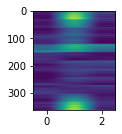

epoch : 19/20, loss = 1.657412648e-02


True

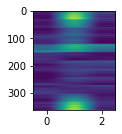

In [33]:
from IPython import display 
from pathlib import Path
from matplotlib import pyplot as plt
import pylab as pl
from ssapp.models.HelperFunctions import saveModel, loadModel

BATCH_SIZE = 1
EPOCHS = 20
CUTS = 20
LATENT_SIZE = 3

data = PatchAntennaDataset()
patch_dataloader = DataLoader(data,batch_size=BATCH_SIZE,shuffle=True)
model = PatchAntenna1ConvAutoEncoder(Latent_size = LATENT_SIZE)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# mean-squared error loss
criterion = nn.MSELoss()
for epoch in range(EPOCHS):
    loss = 0
    for params, field in patch_dataloader:
    # reset the gradients back to zero
    # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        field = field.float()
        # compute reconstructions
        outputs = model(field)
            
        # compute training reconstruction loss
        train_loss = criterion(outputs, field)
            
        # compute accumulated gradients
        train_loss.backward()
            
        # perform parameter update based on current gradients
        optimizer.step()
            
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    loss = loss/(len(patch_dataloader)*BATCH_SIZE)
    
    # display the epoch training loss
    if epoch % (EPOCHS/10) == 0:
        %matplotlib inline
        display.clear_output(wait=True)
        plt.figure(1)
        plt.subplot(211)
        plt.imshow(torch.abs(field[0,:,:,1:2]),aspect=1/100)
        plt.subplot(221)
        plt.imshow(torch.abs(model(field.float())[0,:,:,1:2].detach()),aspect=1/100)
        display.display(pl.gcf())
        print("epoch : {}/{}, loss = {:.9e}".format(epoch + 1, EPOCHS, loss))
    
pth = Path().cwd()
saveModel(model, 'modelTestSave')


In [34]:
len(patch_dataloader)

343

In [35]:
model = loadModel(PatchAntenna1ConvAutoEncoder,'modelTestSave')

from matplotlib import pyplot as plt
params,test_input = next(iter(patch_dataloader))

output = model(test_input.float())

plt.figure()
plt.imshow(torch.abs(test_input[0,:,:,1:2]),aspect=1/100)
plt.figure()
plt.imshow(torch.abs(model(test_input.float())[0,:,:,1:2].detach()),aspect=1/100)
plt.figure()
plt.imshow(torch.abs(test_input[0,:,:,3:4]),aspect=1/100)
plt.figure()
plt.plot(torch.abs(test_input[0,:,0,3:4]))
plt.plot(torch.abs(output[0,:,0,3:4].detach()))


TypeError: super(type, obj): obj must be an instance or subtype of type